Model 3 was selected.  Even though other models had a higher r-squared, model 3 was the only model that did not violate the independence assumption.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

In [2]:
df_RPSale = pd.read_csv("EXTR_RPSale.csv", dtype = str)
df_LookUp = pd.read_csv("EXTR_LookUp.csv", dtype = str)
df_Parcel = pd.read_csv("EXTR_Parcel.csv", dtype = str)
df_ResBldg = pd.read_csv("EXTR_ResBldg.csv", dtype = str)

In [3]:
sale_bldg = df_RPSale.merge(df_Parcel, on = ["Major", "Minor"]).merge(df_ResBldg, on = ["Major", "Minor"] )

In [4]:
cols = list(sale_bldg.columns)
cols = [cols[4]] + cols[:4] + cols[5:]
sale_bldg = sale_bldg[cols]

In [5]:
sale_bldg = sale_bldg.apply(pd.to_numeric, errors='ignore')

In [6]:
sale_bldg=sale_bldg[(sale_bldg.PropertyType==11)|(sale_bldg.PropertyType==12)|(sale_bldg.PropertyType==13)|(sale_bldg.PropertyType==14)|(sale_bldg.PropertyType==18)]

In [7]:
sale_bldg = sale_bldg[sale_bldg.PrincipalUse==6]

In [8]:
features = sale_bldg.filter(['SalePrice', 'SqFtTotLiving', 'BathFullCount', 'Bedrooms', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtTotBasement', 'SqFtFinBasement', 'HeatSource'], axis=1)

In [9]:
sp_over_25k = features[features.SalePrice>25000]

In [10]:
model_3 = sp_over_25k[["SalePrice", "SqFtTotLiving", "SqFtTotBasement"]].copy()
model_3.dropna(inplace=True)

In [11]:
model_3 = ols(formula="SalePrice ~ SqFtTotLiving + SqFtTotBasement", data=model_3)
model_3_results = model_3.fit()

In [12]:
model_3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 1.914e+04
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:55:31   Log-Likelihood:            -1.0137e+06
No. Observations:               70238   AIC:                         2.027e+06
Df Residuals:                   70235   BIC:                         2.027e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.094e+04   4058.861      5.160      0.000     1.3e+04    2.89e+04
SqFtTotLiving     322.2328      1.834    175.723      0.000     318.639     325.827
SqFtTotBasement    70.0906      3.081     22.748      0.000      64.052      76.130
==============================================================================
Omnibus:                   102661.959   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        182911237.529
Skew:                           8.259   Prob(JB):                         0.00
Kurtosis:                     252.454   Cond. No.                     5.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_3_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.2301813621394888
Rainbow p-value: 4.402862358833473e-84


In [14]:
y = sp_over_25k["SalePrice"]
y_hat = model_3_results.predict()

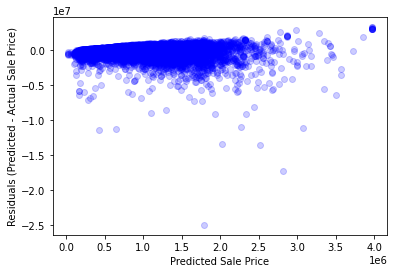

In [15]:
fig5, ax5 = plt.subplots()
ax5.set(xlabel="Predicted Sale Price",
        ylabel="Residuals (Predicted - Actual Sale Price)")
ax5.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2);

In [16]:
rows = sp_over_25k[["SqFtTotLiving", "SqFtTotBasement"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ["SqFtTotLiving", "SqFtTotBasement"]

vif_df

,VIF,feature
0,1.891653,SqFtTotLiving
1,1.891653,SqFtTotBasement


In [17]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

In [18]:
fs_model = forward_selected(sp_over_25k, 'SalePrice')

In [19]:
fs_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     5431.
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:55:34   Log-Likelihood:            -1.0120e+06
No. Observations:               70238   AIC:                         2.024e+06
Df Residuals:                   70229   BIC:                         2.024e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.977e+05   9254.476     32.171      0.000     2.8e+05    3.16e+05
SqFtTotLiving       395.3587      2.750    143.755      0.000     389.968     400.749
Bedrooms          -1.098e+05   2245.815    -48.895      0.000   -1.14e+05   -1.05e+05
SqFtTotBasement     159.9029      5.618     28.462      0.000     148.891     170.914
SqFtFinBasement    -129.0852      7.478    -17.262      0.000    -143.742    -114.428
SqFtOpenPorch       189.8515     14.338     13.241      0.000     161.749     217.954
BathFullCount     -2.029e+04   2930.579     -6.925      0.000    -2.6e+04   -1.46e+04
HeatSource        -2.006e+04   2933.511     -6.837      0.000   -2.58e+04   -1.43e+04
SqFtEnclosedPorch   191.6334     44.326      4.323      0.000     104.755     278.512
==============================================================================
Omnibus:                   102940.527   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        196380554.387
Skew:                           8.280   Prob(JB):                         0.00
Kurtosis:                     261.511   Cond. No.                     1.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
heat_source = sp_over_25k[(sp_over_25k.HeatSource==2)|(sp_over_25k.HeatSource==6)]

In [21]:
heat_source = heat_source[heat_source.SalePrice<5000000]

In [22]:
fs_model_heat_source = forward_selected(heat_source, 'SalePrice')

In [23]:
fs_model_heat_source.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     5758.
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:55:35   Log-Likelihood:            -7.1677e+05
No. Observations:               50286   AIC:                         1.434e+06
Df Residuals:                   50278   BIC:                         1.434e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.499e+05   7033.825     35.530      0.000    2.36e+05    2.64e+05
SqFtTotLiving       376.6714      2.712    138.878      0.000     371.355     381.987
Bedrooms          -1.002e+05   2356.628    -42.535      0.000   -1.05e+05   -9.56e+04
SqFtTotBasement     153.9168      5.954     25.850      0.000     142.246     165.587
SqFtFinBasement    -102.3782      7.835    -13.066      0.000    -117.736     -87.021
SqFtOpenPorch       160.3753     13.817     11.607      0.000     133.294     187.457
BathFullCount      -2.09e+04   2905.829     -7.191      0.000   -2.66e+04   -1.52e+04
SqFtEnclosedPorch   203.2481     51.231      3.967      0.000     102.836     303.660
==============================================================================
Omnibus:                    20725.257   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235534.801
Skew:                           1.668   Prob(JB):                         0.00
Kurtosis:                      13.064   Cond. No.                     1.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fs_model_heat_source)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0151780094287146
Rainbow p-value: 0.116200004199868


In [25]:
y_heat = heat_source["SalePrice"]
y_hat_heat = fs_model_heat_source.predict()

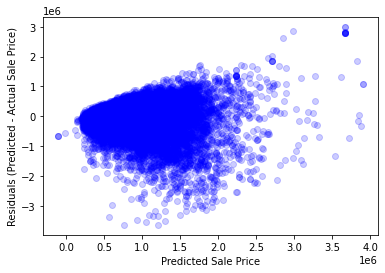

In [26]:
fig5, ax5 = plt.subplots()
ax5.set(xlabel="Predicted Sale Price",
        ylabel="Residuals (Predicted - Actual Sale Price)")
ax5.scatter(x=y_hat_heat, y=y_hat_heat-y_heat, color="blue", alpha=0.2);

In [27]:
rows_heat = heat_source[["SqFtTotLiving", "SqFtTotBasement"]].values

vif_df_heat = pd.DataFrame()
vif_df_heat["VIF"] = [variance_inflation_factor(rows_heat, i) for i in range(2)]
vif_df_heat["feature"] = ["SqFtTotLiving", "SqFtTotBasement"]

vif_df_heat

,VIF,feature
0,1.790948,SqFtTotLiving
1,1.790948,SqFtTotBasement


In [28]:
model_heat = heat_source[["SalePrice", "SqFtTotLiving", "Bedrooms", "HeatSource"]].copy()
model_heat.dropna(inplace=True)

In [29]:
model_heat["HeatSource"].value_counts()

2    50224
6       62
Name: HeatSource, dtype: int64

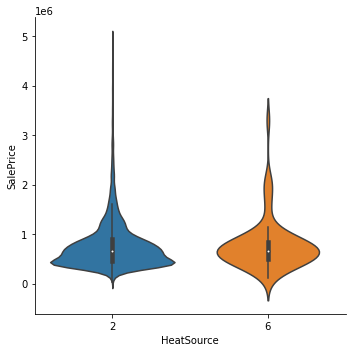

In [30]:
sns.catplot(x="HeatSource", y="SalePrice", data=model_heat, kind="violin");

In [31]:
label_encoder = LabelEncoder()
status_labels_heat = label_encoder.fit_transform(model_heat["HeatSource"])
status_labels_heat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
label_encoder.classes_

array([2, 6], dtype=int64)

In [33]:
model_heat["HeatSource_Status_Encoded"] = status_labels_heat
model_heat.drop("HeatSource", axis=1, inplace=True)

In [34]:
model_3_heat = ols(formula="SalePrice ~ SqFtTotLiving + Bedrooms + HeatSource_Status_Encoded", data=model_heat)
model_3_heat_results = model_3_heat.fit()

In [35]:
model_3_heat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 1.273e+04
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:55:37   Log-Likelihood:            -7.1737e+05
No. Observations:               50286   AIC:                         1.435e+06
Df Residuals:                   50282   BIC:                         1.435e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  2.493e+05   6792.653     36.696      0.000    2.36e+05    2.63e+05
SqFtTotLiving               387.0426      2.194    176.404      0.000     382.742     391.343
Bedrooms                  -1.015e+05   2359.870    -42.997      0.000   -1.06e+05   -9.68e+04
HeatSource_Status_Encoded  4.427e+04   4.82e+04      0.918      0.359   -5.03e+04    1.39e+05
==============================================================================
Omnibus:                    21310.653   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217677.199
Skew:                           1.764   Prob(JB):                         0.00
Kurtosis:                      12.563   Cond. No.                     7.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_3_heat_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0049052204704902
Rainbow p-value: 0.34903440732874863


In [37]:
porch = sp_over_25k.drop(['BathFullCount', 'Bedrooms', 'SqFtFinBasement', 'HeatSource'], axis=1)

In [38]:
porch = porch[porch.SalePrice<5000000]

In [39]:
porch.head()

,SalePrice,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtTotBasement
11,560000,1930,180,0,0
12,435000,1975,45,0,0
17,400000,3180,50,0,1590
19,520000,1380,0,0,0
21,425000,1990,280,0,0


In [40]:
porch[porch.SqFtOpenPorch>0].head()
        

,SalePrice,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtTotBasement
11,560000,1930,180,0,0
12,435000,1975,45,0,0
17,400000,3180,50,0,1590
21,425000,1990,280,0,0
32,1553000,2090,200,0,860


In [41]:
porch['SqFtEnclosedPorch'].values[porch['SqFtEnclosedPorch'].values > 0] = 1

In [42]:
label_encoder = LabelEncoder()
status_labels_porch = label_encoder.fit_transform(porch["SqFtEnclosedPorch"])
status_labels_porch

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
porch["SqFtEnclosedPorch_Status_Encoded"] = status_labels_porch
porch.drop("SqFtEnclosedPorch", axis=1, inplace=True)

In [44]:
fs_model_porch = forward_selected(porch, 'SalePrice')

In [45]:
fs_model_porch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                 1.154e+04
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:55:38   Log-Likelihood:            -9.9804e+05
No. Observations:               70115   AIC:                         1.996e+06
Df Residuals:                   70110   BIC:                         1.996e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         8.011e+04   3439.625     23.289      0.000    7.34e+04    8.68e+04
SqFtTotLiving                      281.7915      1.694    166.373      0.000     278.472     285.111
SqFtTotBasement                     68.5358      2.568     26.690      0.000      63.503      73.569
SqFtOpenPorch                      213.1698     12.064     17.669      0.000     189.524     236.816
SqFtEnclosedPorch_Status_Encoded  7.388e+04   6813.720     10.843      0.000    6.05e+04    8.72e+04
==============================================================================
Omnibus:                    34206.575   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           480300.581
Skew:                           2.000   Prob(JB):                         0.00
Kurtosis:                      15.182   Cond. No.                     1.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fs_model_porch)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9922818792551795
Rainbow p-value: 0.7658746287535503


In [47]:
y_porch = porch["SalePrice"]
y_hat_porch = fs_model_porch.predict()

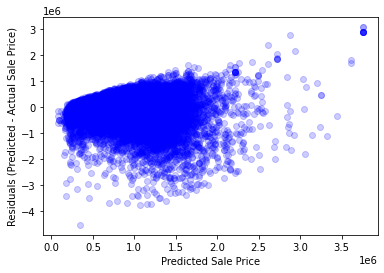

In [48]:
fig5, ax5 = plt.subplots()
ax5.set(xlabel="Predicted Sale Price",
        ylabel="Residuals (Predicted - Actual Sale Price)")
ax5.scatter(x=y_hat_porch, y=y_hat_porch-y_porch, color="blue", alpha=0.2);

In [49]:
rows_porch = porch[["SalePrice", "SqFtOpenPorch"]].values

vif_df_porch = pd.DataFrame()
vif_df_porch["VIF"] = [variance_inflation_factor(rows_porch, i) for i in range(2)]
vif_df_porch["feature"] = ["SalePrice", "SqFtOpenPorch"]

vif_df_porch

,VIF,feature
0,1.42328,SalePrice
1,1.42328,SqFtOpenPorch


In [50]:
sp_over_25k

,SalePrice,SqFtTotLiving,BathFullCount,Bedrooms,SqFtOpenPorch,SqFtEnclosedPorch,SqFtTotBasement,SqFtFinBasement,HeatSource
11,560000,1930,2,3,180,0,0,0,2
12,435000,1975,1,3,45,0,0,0,2
17,400000,3180,1,6,50,0,1590,1590,2
19,520000,1380,1,3,0,0,0,0,1
21,425000,1990,2,3,280,0,0,0,2
...,...,...,...,...,...,...,...,...,...
251286,680000,2270,1,3,0,0,1520,750,1
251288,6500000,440,0,0,0,0,0,0,0
251289,6500000,6390,4,5,890,0,1670,1670,2
251294,440000,2780,3,4,0,0,1590,920,2


In [51]:
basement = sp_over_25k[sp_over_25k.SqFtTotBasement>0]

In [52]:
basement

,SalePrice,SqFtTotLiving,BathFullCount,Bedrooms,SqFtOpenPorch,SqFtEnclosedPorch,SqFtTotBasement,SqFtFinBasement,HeatSource
17,400000,3180,1,6,50,0,1590,1590,2
29,812000,2050,2,4,0,0,1480,200,3
30,370000,1750,2,3,0,0,1130,460,2
32,1553000,2090,2,4,200,0,860,120,2
52,530000,1090,1,2,30,0,440,180,2
...,...,...,...,...,...,...,...,...,...
251278,828130,2340,2,3,0,0,2340,0,2
251284,980000,2660,1,6,40,0,1080,1080,2
251286,680000,2270,1,3,0,0,1520,750,1
251289,6500000,6390,4,5,890,0,1670,1670,2


In [53]:
basement['UnfinishedBasement'] = basement['SqFtTotBasement'] - basement['SqFtFinBasement']

<ipython-input-53-684b57efc7e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basement['UnfinishedBasement'] = basement['SqFtTotBasement'] - basement['SqFtFinBasement']
